In [128]:
import numpy as np
import pandas as pd

In [129]:
prices= pd.read_csv("/content/Natural_Gas_Data prices.csv")   #input price csv

In [130]:
inventory=pd.read_csv("/content/inventory.csv")
position= pd.read_csv("/content/Natural_Gas_Data positioning.csv")
HDD=pd.read_csv("/content/HDD.csv")
CDD=pd.read_csv("/content/CDD.csv")

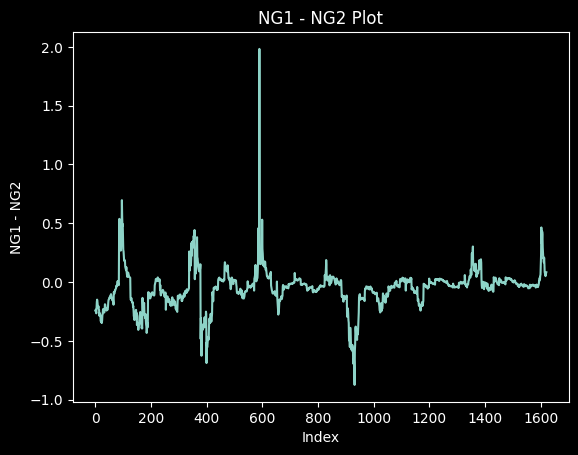

In [131]:
import matplotlib.pyplot as plt

plt.plot(prices['NG1'] - prices['NG2'])
plt.xlabel('Index')
plt.ylabel('NG1 - NG2')
plt.title('NG1 - NG2 Plot')
plt.show()

In [132]:
corr = prices['NG1'].corr(prices['NG2'])
print(f"NG1-NG2 Correlation: {corr}")

NG1-NG2 Correlation: 0.995319907904935


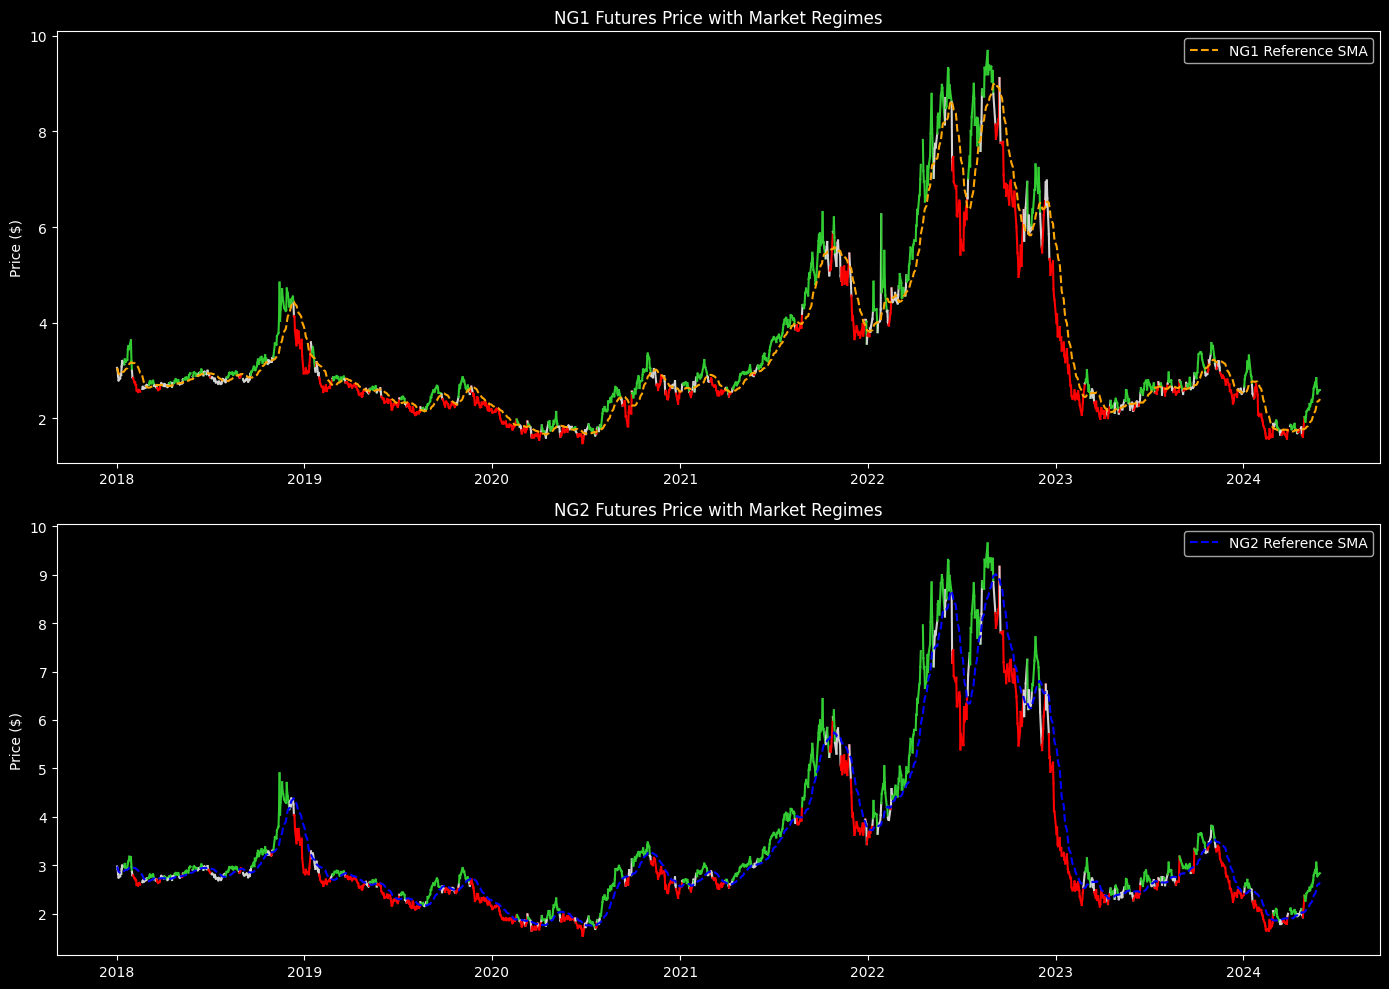

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class NaturalGasCUSUM:
    def __init__(self, ng1_data, ng2_data, dates, window_size=20, delta=2.0):
        self.ng1 = pd.Series(ng1_data)
        self.ng2 = pd.Series(ng2_data)
        self.dates = pd.to_datetime(dates)
        self.window_size = window_size
        self.delta = delta

        # Compute CUSUM for both NG1 and NG2
        self.ng1_cusum_up, self.ng1_cusum_down, self.ng1_reference, self.ng1_thresholds = self._compute_cusum(self.ng1)
        self.ng2_cusum_up, self.ng2_cusum_down, self.ng2_reference, self.ng2_thresholds = self._compute_cusum(self.ng2)

    def _compute_cusum(self, price_series):
        """Compute rolling mean, volatility, and CUSUM values for a given price series."""
        reference = price_series.rolling(window=self.window_size, min_periods=1).mean().ffill()
        volatility = price_series.rolling(10).std().ffill()
        thresholds = self.delta * volatility

        cusum_up = np.zeros(len(price_series))
        cusum_down = np.zeros(len(price_series))

        for i in range(1, len(price_series)):
            dev = price_series.iloc[i] - reference.iloc[i]
            if dev > 0:
                cusum_up[i] = cusum_up[i-1] + dev
                cusum_down[i] = 0
            else:
                cusum_down[i] = cusum_down[i-1] + abs(dev)
                cusum_up[i] = 0

        return cusum_up, cusum_down, reference, thresholds

    def detect_regimes(self, cusum_up, cusum_down, reference, thresholds, price_series):
        """Detect market regimes for a given price series."""
        regimes = pd.Series('Neutral', index=self.dates)

        up_mask = (cusum_up > thresholds) & (price_series > reference)
        down_mask = (cusum_down > thresholds) & (price_series < reference)

        regimes[up_mask] = 'Bullish'
        regimes[down_mask] = 'Bearish'

        return regimes

    def plot_results(self):

        plt.figure(figsize=(14, 10))

        # Detect separate regimes
        ng1_regimes = self.detect_regimes(self.ng1_cusum_up, self.ng1_cusum_down, self.ng1_reference, self.ng1_thresholds, self.ng1)
        ng2_regimes = self.detect_regimes(self.ng2_cusum_up, self.ng2_cusum_down, self.ng2_reference, self.ng2_thresholds, self.ng2)

        ng1_colors = ng1_regimes.map({'Bullish': 'limegreen', 'Bearish': 'red', 'Neutral': 'lightgray'})
        ng2_colors = ng2_regimes.map({'Bullish': 'limegreen', 'Bearish': 'red', 'Neutral': 'lightgray'})

        # NG1 Plot
        ax1 = plt.subplot(2, 1, 1)
        for i in range(len(self.dates) - 1):
            plt.plot(self.dates[i:i+2], self.ng1.iloc[i:i+2], color=ng1_colors.iloc[i], linewidth=1.5)

        plt.plot(self.dates, self.ng1_reference, '--', color='orange', label='NG1 Reference SMA')
        plt.title('NG1 Futures Price with Market Regimes')
        plt.ylabel('Price ($)')
        plt.legend()

        # NG2 Plot
        ax2 = plt.subplot(2, 1, 2, sharex=ax1)
        for i in range(len(self.dates) - 1):
            plt.plot(self.dates[i:i+2], self.ng2.iloc[i:i+2], color=ng2_colors.iloc[i], linewidth=1.5)

        plt.plot(self.dates, self.ng2_reference, '--', color='blue', label='NG2 Reference SMA')
        plt.title('NG2 Futures Price with Market Regimes')
        plt.ylabel('Price ($)')
        plt.legend()

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    df = pd.read_csv("Natural_Gas_Data prices.csv", parse_dates=['Date'], dayfirst=True)
    df = df.sort_values('Date').set_index('Date')

    ng_analyzer = NaturalGasCUSUM(
        ng1_data=df['NG1'],
        ng2_data=df['NG2'],
        dates=df.index,
        window_size=20,
        delta=2.0
    )

    # Detect regimes and add them to DataFrame
    df['NG1_Regime'] = ng_analyzer.detect_regimes(
        ng_analyzer.ng1_cusum_up, ng_analyzer.ng1_cusum_down,
        ng_analyzer.ng1_reference, ng_analyzer.ng1_thresholds,
        ng_analyzer.ng1
    )

    df['NG2_Regime'] = ng_analyzer.detect_regimes(
        ng_analyzer.ng2_cusum_up, ng_analyzer.ng2_cusum_down,
        ng_analyzer.ng2_reference, ng_analyzer.ng2_thresholds,
        ng_analyzer.ng2
    )

    ng_analyzer.plot_results()

In [134]:
import pandas as pd
import numpy as np

class NaturalGasStrategy:
    def __init__(self, df):
        self.df = df.copy()
        self._validate_input()
        self._clean_input()
        self._generate_signals()

    def _validate_input(self):
        """Ensure required input columns are present."""

        required_columns = {'NG1', 'NG2', 'NG1_Regime', 'NG2_Regime'}
        missing_columns = required_columns - set(self.df.columns)

        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

    def _clean_input(self):
        """Handle NaN values in input columns."""

        self.df['NG1'] = self.df['NG1'].fillna(method='ffill').fillna(0)
        self.df['NG2'] = self.df['NG2'].fillna(method='ffill').fillna(0)
        self.df['NG1_Regime'] = self.df['NG1_Regime'].fillna('Neutral')
        self.df['NG2_Regime'] = self.df['NG2_Regime'].fillna('Neutral')

    def _compute_technical_indicators(self):
        """Compute EMA and MACD indicators for NG1 and NG2."""

        for contract in ['NG1', 'NG2']:
            self.df[f'EMA_9_{contract}'] = self.df[contract].ewm(span=9, adjust=False).mean()
            self.df[f'EMA_12_{contract}'] = self.df[contract].ewm(span=12, adjust=False).mean()
            self.df[f'EMA_15_{contract}'] = self.df[contract].ewm(span=15, adjust=False).mean()

            self.df[f'MACD_{contract}'] = self.df[f'EMA_9_{contract}'] - self.df[f'EMA_12_{contract}']
            self.df[f'MACD_Signal_{contract}'] = self.df[f'MACD_{contract}'].ewm(span=9, adjust=False).mean()
            self.df[f'MACD_Histogram_{contract}'] = self.df[f'MACD_{contract}'] - self.df[f'MACD_Signal_{contract}']

    def _generate_signals(self):
        """Generate trading signals based on EMA, MACD Histogram, and regime confirmations."""

        self._compute_technical_indicators()

        self.df['Signal_NG1'] = 0
        self.df['Signal_NG2'] = 0
        self.df['Position_NG1'] = 0
        self.df['Position_NG2'] = 0

        signal_ng1, signal_ng2 = [0] * len(self.df), [0] * len(self.df)
        position_ng1, position_ng2 = [0] * len(self.df), [0] * len(self.df)

        current_pos_ng1, current_pos_ng2 = 0, 0

        for i in range(1, len(self.df)):
            row, prev_row = self.df.iloc[i], self.df.iloc[i - 1]

            # NG1 Signal Logic
            ng1_price_up = row['EMA_12_NG1'] > prev_row['EMA_12_NG1']
            ng1_macd_bullish = row['MACD_Histogram_NG1'] > prev_row['MACD_Histogram_NG1']
            ng1_macd_bearish = row['MACD_Histogram_NG1'] < prev_row['MACD_Histogram_NG1']
            ng1_regime = row['NG1_Regime']
            prev_ng1_regime = prev_row['NG1_Regime']

            if ng1_price_up and ng1_regime == 'Bullish' and prev_ng1_regime == 'Bullish':
                signal_ng1[i] = 1 if current_pos_ng1 <= 0 else 2
                current_pos_ng1 = 1
            elif ng1_macd_bearish and ng1_regime == 'Bearish' and prev_ng1_regime == 'Bearish':
                signal_ng1[i] = -1 if current_pos_ng1 >= 0 else -2
                current_pos_ng1 = -1
            elif ng1_regime == 'Neutral' and prev_ng1_regime == 'Neutral' and current_pos_ng1 != 0:
                signal_ng1[i] = 0
                current_pos_ng1 = 0

            # NG2 Signal Logic
            ng2_price_up = row['EMA_12_NG2'] > prev_row['EMA_12_NG2']
            ng2_macd_bullish = row['MACD_Histogram_NG2'] > prev_row['MACD_Histogram_NG2']
            ng2_macd_bearish = row['MACD_Histogram_NG2'] < prev_row['MACD_Histogram_NG2']
            ng2_regime = row['NG2_Regime']
            prev_ng2_regime = prev_row['NG2_Regime']

            if ng2_price_up and ng2_regime == 'Bullish' and prev_ng2_regime == 'Bullish':
                signal_ng2[i] = 1 if current_pos_ng2 <= 0 else 2
                current_pos_ng2 = 1
            elif ng2_macd_bearish and ng2_regime == 'Bearish' and prev_ng2_regime == 'Bearish':
                signal_ng2[i] = -1 if current_pos_ng2 >= 0 else -2
                current_pos_ng2 = -1
            elif ng2_regime == 'Neutral' and prev_ng2_regime == 'Neutral' and current_pos_ng2 != 0:
                signal_ng2[i] = 0
                current_pos_ng2 = 0

            position_ng1[i] = current_pos_ng1
            position_ng2[i] = current_pos_ng2

        self.df['Signal_NG1'] = signal_ng1
        self.df['Signal_NG2'] = signal_ng2
        self.df['Position_NG1'] = position_ng1
        self.df['Position_NG2'] = position_ng2

    def get_signals(self):

        return self.df[['NG1', 'NG2', 'NG1_Regime', 'NG2_Regime', 'Signal_NG1', 'Signal_NG2', 'Position_NG1', 'Position_NG2']].copy()

if __name__ == "__main__":
    strategy = NaturalGasStrategy(df)
    df = strategy.get_signals()


<ipython-input-134-40953b04cd2c>:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df['NG1'] = self.df['NG1'].fillna(method='ffill').fillna(0)
<ipython-input-134-40953b04cd2c>:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df['NG2'] = self.df['NG2'].fillna(method='ffill').fillna(0)


In [135]:
inventory=inventory[::-1]
position=position[::-1]
HDD=HDD[::-1]
CDD=CDD[::-1]

In [136]:
df.reset_index(inplace=True)

In [137]:
position['Date'] = pd.to_datetime(position['Date'], format='%d-%m-%Y')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
inventory['Date'] = pd.to_datetime(inventory['Date'], format='%d-%m-%Y')
HDD['Date'] = pd.to_datetime(HDD['Date'], format='%d-%m-%Y')
CDD['Date'] = pd.to_datetime(CDD['Date'], format='%d-%m-%Y')

# Merge all DataFrames on 'Date' using Outer Join
merged_df = (
    df.merge(position, on='Date', how='outer')
      .merge(inventory, on='Date', how='outer')
      .merge(CDD, on='Date', how='outer')
      .merge(HDD, on='Date', how='outer')
)

# Sort by 'Date' in ascending order (oldest to most recent)
merged_df.sort_values(by='Date', ascending=True, inplace=True)

# Fill missing values appropriately
merged_df.fillna({
    'NG1': 0, 'NG2': 0,                        # Prices: 0 if no data
    'Producers': 0, 'Swaps': 0,                # Positions: 0 if no data
    'Managed Money': 0, 'Other Reportable': 0,
    'Non-reportable': 0, 'Abs total': 0,
    'Inventory (BCF)': 0,                      # Inventory: 0 if no data
    'HDD': merged_df['HDD'].ffill(),           # Forward-fill temperature values
    'CDD': merged_df['CDD'].ffill(),
}, inplace=True)


In [138]:
import pandas as pd

columns_to_process = ['Producers', 'Swaps', 'Managed Money', 'Other Reportable', 'Non-reportable', 'Abs total']
for col in columns_to_process:
    merged_df[col] = merged_df[col].replace(0, pd.NA).ffill()

In [139]:
merged_df = merged_df[~((merged_df['NG1'] == 0) & (merged_df['NG2'] == 0))]

In [140]:
merged_df.fillna(0, inplace=True)

<ipython-input-140-f59210643da4>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.fillna(0, inplace=True)


In [141]:
df=merged_df.copy()

In [142]:
import pandas as pd
import numpy as np

# Ensure NG1 and NG2 are numeric
df['NG1'] = pd.to_numeric(df['NG1'], errors='coerce').ffill().fillna(df['NG1'].mean())
df['NG2'] = pd.to_numeric(df['NG2'], errors='coerce').ffill().fillna(df['NG2'].mean())

# Compute fundamental metrics
df['Net_Position'] = df['Managed Money'] + df['Swaps'] - df['Producers']
df['Sentiment_Score'] = df['Net_Position'] / df['Abs total']
df['Inventory_zscore'] = (df['Inventory (unit: BCF)'] - df['Inventory (unit: BCF)'].rolling(30).mean()) / df['Inventory (unit: BCF)'].rolling(30).std()
df['Total_DD'] = df['HDD'] + df['CDD']
df['Demand_Change'] = df['Total_DD'].pct_change().fillna(0)

# Smooth fundamentals with 10-day EMA
df['Sentiment_Score_EMA'] = df['Sentiment_Score'].ewm(span=10, adjust=False).mean().fillna(0)
df['Inventory_zscore_EMA'] = df['Inventory_zscore'].ewm(span=10, adjust=False).mean().fillna(0)
df['Demand_Change_EMA'] = df['Demand_Change'].ewm(span=10, adjust=False).mean().fillna(0)

# Compute price dynamics
df['NG1_velocity'] = df['NG1'].diff().fillna(0)
df['NG2_velocity'] = df['NG2'].diff().fillna(0)
df['NG1_jerk'] = df['NG1_velocity'].diff().diff().fillna(0)  # Second diff for jerk
df['NG2_jerk'] = df['NG2_velocity'].diff().diff().fillna(0)
df['NG1_volatility'] = df['NG1'].pct_change().rolling(window=14).std().fillna(0)
df['NG2_volatility'] = df['NG2'].pct_change().rolling(window=14).std().fillna(0)

# Initialize output columns
df['Holding'] = np.nan
df['Holding'] = df['Holding'].astype('object')
df['Current_Signal'] = np.nan
df['Switch'] = False

# Set initial values
df.iloc[0, df.columns.get_loc('Holding')] = 'NG2'
df.iloc[0, df.columns.get_loc('Current_Signal')] = df.iloc[0]['Signal_NG2']

# Switching logic
threshold = 0.005  # Small static threshold to avoid noise
for i in range(1, len(df)):
    row = df.iloc[i]
    prev_holding = df.iloc[i - 1]['Holding']

    # Weighted scores
    score_ng1 = (
        0.4 * abs(row['NG1_velocity']) +
        0.3 * abs(row['NG1_jerk']) +
        0.1 * row['NG1_volatility'] +
        0.1 * abs(row['Sentiment_Score_EMA']) +
        0.05 * abs(row['Inventory_zscore_EMA']) +
        0.05 * abs(row['Demand_Change_EMA'])
    )
    score_ng2 = (
        0.4 * abs(row['NG2_velocity']) +
        0.3 * abs(row['NG2_jerk']) +
        0.1 * row['NG2_volatility'] +
        0.1 * abs(row['Sentiment_Score_EMA']) +
        0.05 * abs(row['Inventory_zscore_EMA']) +
        0.05 * abs(row['Demand_Change_EMA'])
    )

    # Switching decision
    if score_ng1 > score_ng2 + threshold:
        new_holding = 'NG1'
    elif score_ng2 > score_ng1 + threshold:
        new_holding = 'NG2'
    else:
        new_holding = prev_holding

    # Track switch
    if new_holding != prev_holding:
        df.iloc[i, df.columns.get_loc('Switch')] = True

        # Close previous position
        if prev_holding == 'NG1' and df.iloc[i-1]['Position_NG1'] != 0:
            df.iloc[i, df.columns.get_loc('Position_NG1')] = 0
        elif prev_holding == 'NG2' and df.iloc[i-1]['Position_NG2'] != 0:
            df.iloc[i, df.columns.get_loc('Position_NG2')] = 0

    # Update holding and signal
    df.iloc[i, df.columns.get_loc('Holding')] = new_holding
    df.iloc[i, df.columns.get_loc('Current_Signal')] = row['Signal_NG1'] if new_holding == 'NG1' else row['Signal_NG2']

    # Update position
    if new_holding == 'NG1':
        df.iloc[i, df.columns.get_loc('Position_NG1')] = row['Signal_NG1']
    else:
        df.iloc[i, df.columns.get_loc('Position_NG2')] = row['Signal_NG2']


columns_to_drop = ['NG1_velocity', 'NG2_velocity', 'NG1_jerk', 'NG2_jerk', 'NG1_volatility', 'NG2_volatility',
                   'Net_Position', 'Sentiment_Score', 'Inventory_zscore', 'Total_DD', 'Demand_Change',
                   'Sentiment_Score_EMA', 'Inventory_zscore_EMA', 'Demand_Change_EMA']
df = df.drop(columns=columns_to_drop, errors='ignore')

In [143]:
df= df[['Date', 'NG1', 'NG2', 'NG1_Regime', 'NG2_Regime', 'Signal_NG1', 'Signal_NG2', 'Position_NG1', 'Position_NG2', 'Holding', 'Current_Signal', 'Switch']]

In [144]:
df = df.reset_index()

In [145]:
import pandas as pd
import numpy as np

# Step 1: Ensure 'Date' is a DatetimeIndex and a column
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.set_index('Date', drop=False)

# Step 2: Convert columns to numeric

df['NG1'] = pd.to_numeric(df['NG1'], errors='coerce')
df['NG2'] = pd.to_numeric(df['NG2'], errors='coerce')
df['Current_Signal'] = pd.to_numeric(df['Current_Signal'], errors='coerce').fillna(0)
df['Switch'] = pd.to_numeric(df['Switch'], errors='coerce').fillna(0)

# Step 3: Initialize output columns

df['signals'] = 0
df['current_position'] = 0



current_position = 0
current_holding = df['Holding'].iloc[0]

# Step 4: Process signals and positions with carry forward
for i in range(len(df)):
    holding = df['Holding'].iloc[i]
    switch = df['Switch'].iloc[i]
    signal = df['Current_Signal'].iloc[i]
    prev_holding = df['Holding'].iloc[i-1] if i > 0 else current_holding


    if i > 0 and switch == 1 :
        # Rollover: Carry forward the existing position to the new contract
        current_holding = holding
        pow_=1
        if current_position != 0:
            df.loc[df.index[i], 'signals'] = 0

        if signal == 1:
            if current_position == 0:
                current_position = 1
                df.loc[df.index[i], 'signals'] = 1  # Enter long
            elif current_position == -1:
                if pow_==1:
                  df.loc[df.index[i], 'signals'] = 2
                  pow_=0
                  current_position = 1
                else:
                  df.loc[df.index[i], 'signals'] = 1
                  current_position = 0   # Close short and go long
            else:
                df.loc[df.index[i], 'signals'] = 0

        elif signal == -1:
            if current_position == 0:
                current_position = -1
                df.loc[df.index[i], 'signals'] = -1  # Enter short
            elif current_position == 1:
                if pow_==1:
                  df.loc[df.index[i], 'signals'] = -2  # Close long and go short
                  pow_=0
                  current_position = -1
                else:
                  df.loc[df.index[i], 'signals'] = -1
                  current_position = 0  # Close long and go short
            else:
                df.loc[df.index[i], 'signals'] = 0

        elif signal == 2:
            if current_position == 1:
                current_position = 1
                df.loc[df.index[i], 'signals'] = 0  # Reverse to short
            elif current_position == -1:
                current_position = 1
                df.loc[df.index[i], 'signals'] = 2  # Enter short
            else:
                df.loc[df.index[i], 'signals'] = 0  # Already short
        elif signal == -2:
            if current_position == -1:
                current_position = -1
                df.loc[df.index[i], 'signals'] = 0  # Reverse to long
            elif current_position == 1:
                current_position = -1
                df.loc[df.index[i], 'signals'] = -2  # Enter long
            else:
                df.loc[df.index[i], 'signals'] = 0  # Already long
        elif signal == 0:
            df.loc[df.index[i], 'signals'] = 0  # No action, maintain position


    # No switch: update position based on Current_Signal
    else:
        if signal == 1:
            if current_position == 0:
                current_position = 1
                df.loc[df.index[i], 'signals'] = 1  # Enter long
            elif current_position == -1:
                if pow_==1:
                  df.loc[df.index[i], 'signals'] = 2
                  pow_=0
                  current_position = 1
                else:
                  df.loc[df.index[i], 'signals'] = 1
                  current_position = 0   # Close short and go long
            else:
                df.loc[df.index[i], 'signals'] = 0

        elif signal == -1:
            if current_position == 0:
                current_position = -1
                df.loc[df.index[i], 'signals'] = -1  # Enter short
            elif current_position == 1:
                if pow_==1:
                  df.loc[df.index[i], 'signals'] = -2  # Close long and go short
                  pow_=0
                  current_position = -1
                else:
                  df.loc[df.index[i], 'signals'] = -1
                  current_position = 0  # Close long and go short
            else:
                df.loc[df.index[i], 'signals'] = 0

        elif signal == 2:
            if current_position == 1:
                current_position = 1
                df.loc[df.index[i], 'signals'] = 0  # Reverse to short
            elif current_position == -1:
                current_position = 1
                df.loc[df.index[i], 'signals'] = 2  # Enter short
            else:
                df.loc[df.index[i], 'signals'] = 0  # Already short
        elif signal == -2:
            if current_position == -1:
                current_position = -1
                df.loc[df.index[i], 'signals'] = 0  # Reverse to long
            elif current_position == 1:
                current_position = -1
                df.loc[df.index[i], 'signals'] = -2  # Enter long
            else:
                df.loc[df.index[i], 'signals'] = 0  # Already long
        elif signal == 0:
            df.loc[df.index[i], 'signals'] = 0  # No action, maintain position

    # Update current_position column
    df.loc[df.index[i], 'current_position'] = current_position

output_columns = ['Date', 'NG1', 'NG2', 'Holding', 'Switch', 'Current_Signal', 'signals', 'current_position']
output_df = df[output_columns]

In [146]:
for i in range(len(df)):
    current_position_ = df['current_position'].iloc[i-1]  # Get current position
    current_position_1 = df['current_position'].iloc[i]
    switch = df['Switch'].iloc[i]

    if switch and current_position != 0 :
        # Adjust previous signal
        if i > 0:
          df.loc[df.index[i], 'signals'] = current_position_1
        # Set current signal
        df.loc[df.index[i], 'edge_signals'] = -current_position_

In [147]:
columns_to_remove = ['edge_signals', 'Signal_NG1', 'Position_NG1', 'current_Signal']
df = df.drop(columns=columns_to_remove, errors='ignore')

In [148]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd

def process_contracts(df):

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date', drop=False)
    trading_days = df.index.unique()

    # Preprocess numeric columns
    numeric_cols = ['Switch', 'Position_NG2']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Calculate expiry dates (last Thursday of the month)
    def get_last_thursday(year, month):
        month_end = pd.Timestamp(year=year, month=month, day=1) + MonthEnd(1)
        days = pd.date_range(start=month_end - pd.offsets.MonthBegin(), end=month_end)
        thursdays = days[days.weekday == 3]
        return thursdays[-1] if not thursdays.empty else None

    # Add expiry date column
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['expiry_date'] = df.apply(lambda x: get_last_thursday(x['year'], x['month']), axis=1)

    # Adjust expiry to last trading day
    def adjust_expiry(expiry, trading_days):
        if expiry in trading_days:
            return expiry
        valid_days = trading_days[trading_days <= expiry]
        return valid_days.max() if not valid_days.empty else None

    df['expiry_date'] = df['expiry_date'].apply(lambda x: adjust_expiry(x, trading_days))
    df['is_expiry'] = df.index == df['expiry_date']


    for i in range(1, len(df)):
        row = df.iloc[i]
        date = row.name
        expiry_date = row['expiry_date']
        prev_row = df.iloc[i - 1]


        current_position = row['current_position']
        previous_holding = prev_row['Holding']
        previous_position = prev_row['current_position']

        # ---  On Expiry Day: Close NG1 Position ---
        if row['is_expiry'] and previous_holding == 'NG1' and previous_position != 0:
            # Close NG1 position
            df.at[date, 'signals'] = -previous_position  # Square off the existing position
            df.at[date, 'Holding'] = 'NG2' if row['Switch'] else 'NG1'
            edge_signal = 'Switched to NG2 on expiry (Switch = True)' if row['Switch'] else 'Closed NG1 on expiry (Switch = False)'
            df.at[date, 'edge_signals'] = edge_signal

        # ---  On Next Day After Expiry: Switch to NG2 if Position Remains ---
        elif prev_row['is_expiry'] and previous_position != 0 and row['Holding'] != 'NG2':
            # Reopen or continue position in NG2
            df.at[date, 'Holding'] = 'NG2'
            df.at[date, 'signals'] = previous_position  # Maintain the same position
            df.at[date, 'current_position'] = previous_position
            df.at[date, 'edge_signals'] = 'Maintained NG2 post-expiry with same position'



    df.drop(columns=['year', 'month', 'expiry_date', 'is_expiry'], inplace=True, errors='ignore')
    return df


processed_df = process_contracts(df)


In [149]:
processed_df = processed_df[['Date','NG1','NG2', 'Holding', 'signals']]

In [150]:
processed_df = processed_df.copy()

processed_df.loc[:, 'Switch'] = processed_df['Holding'].ne(processed_df['Holding'].shift())
processed_df.loc[processed_df.index[0], 'Switch'] = False

In [151]:
import pandas as pd
import numpy as np

def calculate_position(df):

    df['position'] = 0

    for i in range(len(df)):

        row = df.iloc[i]
        prev_position = df.iloc[i - 1]['position'] if i > 0 else 0

        current_signal = row['signals']
        switch = row['Switch']  # Check if switch is True

        # ---  On Switch Day: Set position = signals or 0 if signal is 0 ---
        if switch:
            if current_signal != 0:
                df.at[df.index[i], 'position'] = current_signal
            else:
                df.at[df.index[i], 'position'] = 0  # Reset to zero when signal is zero

        # ---  No Switch: Let position evolve based on signals ---
        else:
            if current_signal == 1:
                # Enter long or exit short
                if prev_position <= 0:
                    df.at[df.index[i], 'position'] = 1
                else:
                    df.at[df.index[i], 'position'] = prev_position

            elif current_signal == -1:
                # Enter short or exit long
                if prev_position >= 0:
                    df.at[df.index[i], 'position'] = -1
                else:
                    df.at[df.index[i], 'position'] = prev_position

            elif current_signal == 2:
                # Switch from short to long
                if prev_position < 0:
                    df.at[df.index[i], 'position'] = 1
                else:
                    df.at[df.index[i], 'position'] = prev_position

            elif current_signal == -2:
                # Switch from long to short
                if prev_position > 0:
                    df.at[df.index[i], 'position'] = -1
                else:
                    df.at[df.index[i], 'position'] = prev_position

            elif current_signal == 0:
                # Continue holding previous position
                df.at[df.index[i], 'position'] = prev_position

    return df

processed_df = calculate_position(processed_df)


In [152]:

def calculate_edge_case(df):
    df['edge_case'] = 0  # Initialize the 'edge_case' column

    for i in range(1, len(df)):
        if df['position'].iloc[i - 1] != 0 and df['Switch'].iloc[i]:
            df.loc[df.index[i], 'edge_case'] = -df['position'].iloc[i-1]
        else:
            df.loc[df.index[i], 'edge_case'] = 0
    return df

processed_df = calculate_edge_case(processed_df)


In [153]:
processed_df['close'] = np.where(
    processed_df['Holding'] == 'NG1',
    processed_df['NG1'],  # If Holding is NG1, take NG1 price
    processed_df['NG2']   # If Holding is NG2, take NG2 price
)

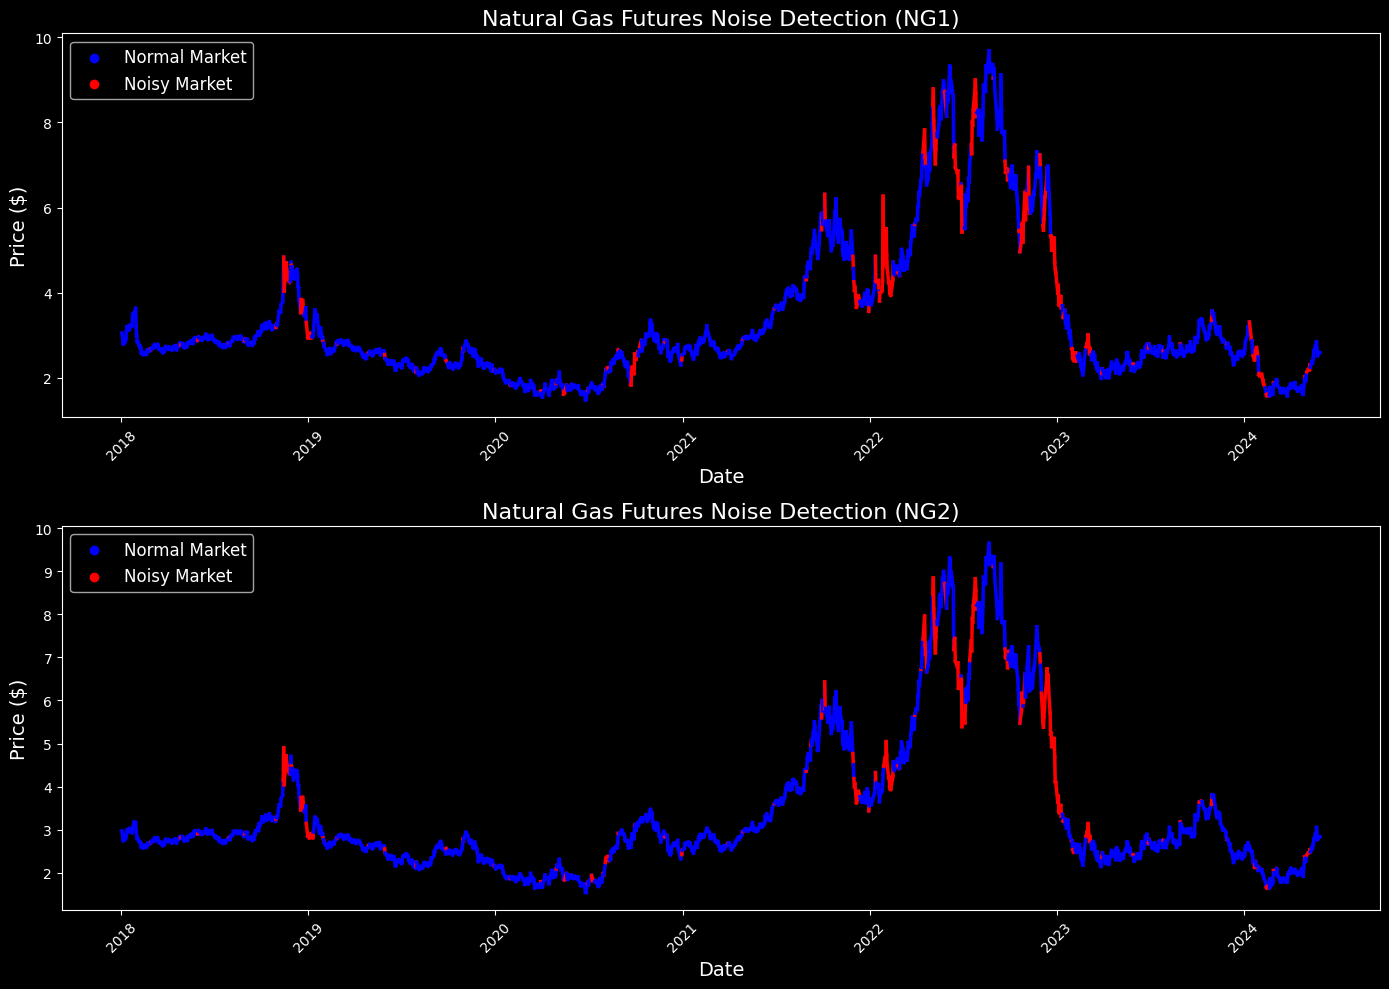

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def ng_fdi(close_prices, window=28, lookback=10):

    fdi = pd.Series(index=close_prices.index, dtype=float)

    for i in range(window + lookback, len(close_prices)):
        price_chunk = close_prices.iloc[i - lookback:i]
        max_price = price_chunk.max()
        min_price = price_chunk.min()

        log_range = np.log(max_price) - np.log(min_price)

        n = window
        fd = 1 + (log_range + np.log(n)) / (np.log(n) ** 0.5)
        fdi.iloc[i] = fd

    month_end_dates = close_prices[close_prices.index.is_month_end]
    fdi.loc[month_end_dates.index] *= 1.05

    return fdi.dropna()

def calculate_noise_alerts(processed_df):

    for col in ['NG1', 'NG2']:
        # Compute FDI for NG1 and NG2
        processed_df[f'FDI_{col}'] = ng_fdi(processed_df[col])

        # Dynamic Noise Threshold (Mean + 1 Std Dev)
        noise_threshold = processed_df[f'FDI_{col}'].mean() + processed_df[f'FDI_{col}'].std()
        processed_df[f'Noise_Alert_{col}'] = processed_df[f'FDI_{col}'] > noise_threshold

    return processed_df

def plot_noise_alerts(processed_df):

    plt.figure(figsize=(14, 10))
    plt.style.use('dark_background')

    for i, col in enumerate(['NG1', 'NG2']):
        plt.subplot(2, 1, i + 1)

        # Create mask for noisy periods
        noisy_mask = processed_df[f'Noise_Alert_{col}'].fillna(False)

        for j in range(1, len(processed_df)):
            color = 'red' if noisy_mask.iloc[j] else 'blue'
            plt.plot(processed_df.index[j-1:j+1], processed_df[col].iloc[j-1:j+1],
                     color=color, linewidth=2.5)

        plt.title(f'Natural Gas Futures Noise Detection ({col})', fontsize=16, color='white')
        plt.xlabel('Date', fontsize=14, color='white')
        plt.ylabel('Price ($)', fontsize=14, color='white')
        plt.xticks(rotation=45, color='white')
        plt.yticks(color='white')
        plt.grid(False)

        plt.scatter([], [], color='blue', label='Normal Market')
        plt.scatter([], [], color='red', label='Noisy Market')
        plt.legend(loc='upper left', fontsize=12)

    plt.tight_layout()
    plt.show()

processed_df = calculate_noise_alerts(processed_df)
plot_noise_alerts(processed_df)


In [155]:
def check_holding_noise(processed_df):

    processed_df['Noise_Alert'] = np.where(
        processed_df['Holding'] == 'NG1',                               # If holding NG1
        processed_df['Noise_Alert_NG1'],                                # Check Noise_Alert_NG1
        np.where(processed_df['Holding'] == 'NG2',                      # If holding NG2
                 processed_df['Noise_Alert_NG2'],                       # Check Noise_Alert_NG2
                 False)
    )

    return processed_df


processed_df = check_holding_noise(processed_df)


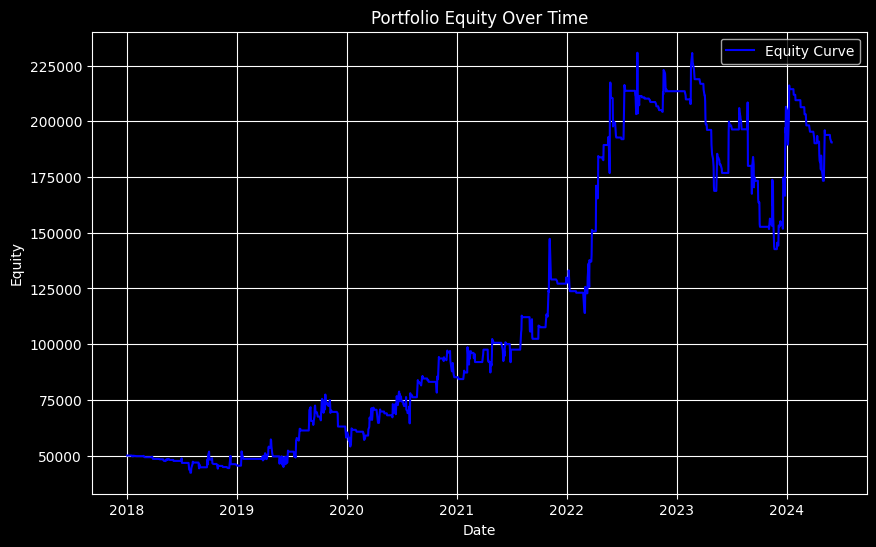


Backtest Performance Summary
-----------------------------------
Total Trades             : 256
Winning Trades           : 112
Win Rate (%)             : 43.75
Profit Percentage (%)    : 273.99
Sharpe Ratio             : 1.79
Sortino Ratio            : 0.77
Max Drawdown             : 88,138.00
Max Drawdown (%)         : 38.19
Final Balance            : 186,996.00

Detailed Trade Log
-------------------------
entry_date  entry_price  position  lots_traded  exit_date  exit_price       pnl take_profit_hit edge_case noise_exit stop_loss_hit
2018-01-17        3.232         7            7 2018-01-23       3.444    1414.0            True       NaN        NaN           NaN
2018-01-25        3.447        -7            7 2018-01-26       3.175    1834.0            True       NaN        NaN           NaN
2018-01-26        3.175         7            7 2018-01-29       3.631    3122.0            True       NaN        NaN           NaN
2018-02-22        2.634         9            9 2018-02-23      

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def backtest_contract(data, signal_col, initial_capital=50000,
                      lot_size=1000, initial_margin_pct=0.10, maintenance_margin_pct=0.08,
                      commission_per_lot=10, risk_free_rate=0.015, kelly_window=3,
                      stop_loss_pct=0.10, take_profit_pct=0.10):

    #Backtest a trading strategy with Kelly Criterion, Noise Alert, Stop-Loss, and Take-Profit based on close price.

    #Parameters:
    #- data: DataFrame with 'Date', 'NG1', 'NG2', 'Holding', 'Switch', 'edge_case', 'signals', 'Noise_Alert'
    #- signal_col: Column name for trading signals
    #- initial_capital: Starting capital (default: 50,000)
    #- lot_size: Size of each contract
    #- initial_margin_pct: Initial margin percentage
    #- maintenance_margin_pct: Maintenance margin percentage
    #- commission_per_lot: Commission per lot
    #- risk_free_rate: Annual risk-free rate
    #- kelly_window: Past trades for Kelly calculation
    #- stop_loss_pct: Stop-loss percentage
    #- take_profit_pct: Take-profit percentage

    #Returns:
    #- Dictionary with performance metrics and trade records

    # Prepare data
    data = data.copy()
    if 'Date' in data.index.names:
        if 'Date' in data.columns:
            data = data.drop(columns=['Date'])
        data = data.reset_index()
    data['Date'] = pd.to_datetime(data['Date'])
    data['close'] = np.where(data['Holding'] == 'NG1', data['NG1'], data['NG2'])

    # Initialize variables
    position = 0
    equity = initial_capital
    trades = []
    equity_series = [equity]
    daily_pnls = []
    last_valid_price = data['close'].iloc[0]
    current_trade = None
    trade_history = []
    stop_loss_level = None
    take_profit_level = None

    # Kelly fraction calculation
    def calculate_kelly_fraction(trade_history, kelly_window):
        if len(trade_history) < kelly_window:
            return 0.05
        recent_trades = trade_history[-kelly_window:]
        wins = [t for t in recent_trades if t > 0]
        losses = [t for t in recent_trades if t < 0]
        win_rate = len(wins) / len(recent_trades) if recent_trades else 0
        avg_win = np.mean(wins) if wins else 0
        avg_loss = np.mean(losses) if losses else 0
        if avg_win == 0 or avg_loss == 0:
            return 0.05
        f = (win_rate * avg_win - (1 - win_rate) * avg_loss) / avg_win
        return max(min(f, 0.25), 0.01)

    # Backtesting loop
    for i in range(len(data)):
        current_price = data['close'].iloc[i]
        last_valid_price = current_price
        signal = data[signal_col].iloc[i] if not pd.isna(data[signal_col].iloc[i]) else 0
        noise_alert = data['Noise_Alert'].iloc[i]

        # Sandwich: Check stop-loss and take-profit if position is open
        if position != 0 and stop_loss_level is not None and take_profit_level is not None:
            # Stop-loss check
            if (position > 0 and current_price <= stop_loss_level) or (position < 0 and current_price >= stop_loss_level):
                realized_pnl = position * (current_price - current_trade['entry_price']) * lot_size - abs(position) * commission_per_lot
                equity -= abs(position) * commission_per_lot
                trades[-1].update({
                    'exit_date': data['Date'].iloc[i],
                    'exit_price': current_price,
                    'pnl': realized_pnl,
                    'stop_loss_hit': True
                })
                trade_history.append(realized_pnl)
                position = 0
                current_trade = None
                stop_loss_level = None
                take_profit_level = None
            # Take-profit check
            elif (position > 0 and current_price >= take_profit_level) or (position < 0 and current_price <= take_profit_level):
                realized_pnl = position * (current_price - current_trade['entry_price']) * lot_size - abs(position) * commission_per_lot
                equity -= abs(position) * commission_per_lot
                trades[-1].update({
                    'exit_date': data['Date'].iloc[i],
                    'exit_price': current_price,
                    'pnl': realized_pnl,
                    'take_profit_hit': True
                })
                trade_history.append(realized_pnl)
                position = 0
                current_trade = None
                stop_loss_level = None
                take_profit_level = None

        # Close position if Noise_Alert is True
        if noise_alert and position != 0:
            realized_pnl = position * (current_price - current_trade['entry_price']) * lot_size - abs(position) * commission_per_lot
            equity -= abs(position) * commission_per_lot
            trades[-1].update({
                'exit_date': data['Date'].iloc[i],
                'exit_price': current_price,
                'pnl': realized_pnl,
                'noise_exit': True
            })
            trade_history.append(realized_pnl)
            position = 0
            current_trade = None
            stop_loss_level = None
            take_profit_level = None

        # Daily P&L calculation
        if position != 0 and i > 0:
            price_diff = current_price - data['close'].iloc[i - 1]
            daily_pnl = position * price_diff * lot_size
            equity += daily_pnl
            daily_pnls.append(daily_pnl)
        else:
            daily_pnls.append(0)

        # Margin check
        if position != 0:
            contract_value = abs(position) * current_price * lot_size
            maintenance_margin = contract_value * maintenance_margin_pct
            if equity < maintenance_margin:
                realized_pnl = position * (current_price - current_trade['entry_price']) * lot_size - abs(position) * commission_per_lot
                equity -= abs(position) * commission_per_lot
                trades[-1].update({
                    'exit_date': data['Date'].iloc[i],
                    'exit_price': current_price,
                    'pnl': realized_pnl,
                    'liquidated': True
                })
                trade_history.append(realized_pnl)
                position = 0
                current_trade = None
                stop_loss_level = None
                take_profit_level = None

        # Handle contract switch (edge case)
        if position != 0 and data['Switch'].iloc[i]:
            exit_holding = data['Holding'].iloc[i - 1]
            exit_price = data[exit_holding].iloc[i]
            if (data['edge_case'].iloc[i] == 1 and position < 0) or (data['edge_case'].iloc[i] == -1 and position > 0):
                realized_pnl = position * (exit_price - current_trade['entry_price']) * lot_size - abs(position) * commission_per_lot
                equity -= abs(position) * commission_per_lot
                trades[-1].update({
                    'exit_date': data['Date'].iloc[i],
                    'exit_price': exit_price,
                    'pnl': realized_pnl,
                    'edge_case': True
                })
                trade_history.append(realized_pnl)
                position = 0
                current_trade = None
                stop_loss_level = None
                take_profit_level = None

        # Trading signals only if Noise_Alert is False and no position is open
        if not noise_alert and position == 0:
            new_position = 0
            if signal == 1 and equity >= current_price * lot_size * initial_margin_pct:
                new_position = 1
            elif signal == -1 and equity >= current_price * lot_size * initial_margin_pct:
                new_position = -1

            # Execute position changes
            if new_position != position:
                if new_position != 0:
                    f = calculate_kelly_fraction(trade_history, kelly_window)
                    capital_to_risk = f * equity
                    required_margin_per_lot = current_price * lot_size * initial_margin_pct
                    max_lots = int(capital_to_risk // required_margin_per_lot)
                    if max_lots >= 1:
                        position = new_position * max_lots
                        current_trade = {
                            'entry_date': data['Date'].iloc[i],
                            'entry_price': current_price,
                            'position': position,
                            'lots_traded': abs(position)
                        }
                        # Set stop-loss and take-profit levels
                        if position > 0:  # Long position
                            stop_loss_level = current_price * (1 - stop_loss_pct)
                            take_profit_level = current_price * (1 + take_profit_pct)
                        else:  # Short position
                            stop_loss_level = current_price * (1 + stop_loss_pct)
                            take_profit_level = current_price * (1 - take_profit_pct)
                        trades.append(current_trade)

        equity_series.append(equity)

    # Close open position at the end
    if position != 0:
        realized_pnl = position * (last_valid_price - current_trade['entry_price']) * lot_size - abs(position) * commission_per_lot
        equity -= abs(position) * commission_per_lot
        trades[-1].update({
            'exit_date': data['Date'].iloc[-1],
            'exit_price': last_valid_price,
            'pnl': realized_pnl
        })

    # Performance metrics
    total_trades = len(trades)
    winning_trades = sum(1 for t in trades if 'pnl' in t and t['pnl'] > 0)
    win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
    profit_percentage = ((equity - initial_capital) / initial_capital) * 100

    equity_df = pd.DataFrame({'equity': equity_series})
    returns = equity_df['equity'].pct_change().dropna()
    smoothed_returns = returns.rolling(window=5, min_periods=1).mean()
    excess_returns = smoothed_returns - (risk_free_rate / 252)
    sharpe_ratio = np.sqrt(252) * (excess_returns.mean() / excess_returns.std()) if excess_returns.std() != 0 else np.nan
    downside_returns = returns[returns < 0]
    sortino_ratio = np.sqrt(252) * (excess_returns.mean() / downside_returns.std()) if downside_returns.std() != 0 else np.nan

    equity_df['peak'] = equity_df['equity'].cummax()
    equity_df['drawdown'] = equity_df['peak'] - equity_df['equity']
    max_drawdown = equity_df['drawdown'].max()
    max_drawdown_pct = (max_drawdown / equity_df['peak'].max()) * 100 if equity_df['peak'].max() > 0 else 0

    trades_df = pd.DataFrame(trades)

    # Plot equity curve
    plt.figure(figsize=(10, 6))
    plt.plot(data['Date'], equity_series[:-1], label='Equity Curve', color='blue')
    plt.xlabel('Date')
    plt.ylabel('Equity')
    plt.title('Portfolio Equity Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        "Total Trades": total_trades,
        "Winning Trades": winning_trades,
        "Win Rate (%)": win_rate,
        "Profit Percentage (%)": profit_percentage,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Max Drawdown (%)": max_drawdown_pct,
        "Final Balance": equity,
        "Trade Records": trades_df
    }

result = backtest_contract(processed_df, 'signals', kelly_window=12, stop_loss_pct=0.03, take_profit_pct=0.06)

print("\nBacktest Performance Summary")
print("-" * 35)
for k, v in result.items():
     if k != "Trade Records":
         print(f"{k:<25}: {v:,.2f}" if isinstance(v, float) else f"{k:<25}: {v}")

print("\nDetailed Trade Log")
print("-" * 25)
if result['Trade Records'].empty:
     print("No trades were executed.")
else:
     print(result['Trade Records'].to_string(index=False))